In [32]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage, elo_save_feature
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
import glob
from joblib import Parallel, delayed

key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
base = utils.read_pkl_gzip('../input/base_type_group.gz')[[key, target, 'type', 'clf_pred', 'no_out_flg']].set_index(key)

#========================================================================
# 予測値を結合する
submit_list = glob.glob('../ensemble/good_submit_ensemble/*')
submit_list = glob.glob('../ensemble/good_submit_ensemble/tmp/*.gz') + glob.glob('../ensemble/good_submit_ensemble/tmp/*.csv')
for path in submit_list:
    cv = 'CV' + re.search(r'CV([^/.]*)_LB', path.replace('.', '-')).group(1)
    if path.count('gz'):
        tmp = utils.read_pkl_gzip(path)[[key, 'prediction']].set_index(key)
        lb = 'LB' + re.search(r'LB([^/.]*).gz', path.replace('.', '-')).group(1)
    else:
        tmp = pd.read_csv(path)[[key, 'prediction']].set_index(key)
        lb = 'LB' + re.search(r'LB([^/.]*).csv', path.replace('.', '-')).group(1)
    print(lb, cv)
    if path.count('1130'):
        base['LB_CV_pp_02231130'] = tmp
    elif path.count('1120'):
        base['LB_CV_pp_02231120'] = tmp
    else:
        base[f"{lb}_{cv[:9]}"] = tmp
        
base.head()
#======================================================================

LB3-500 CV3-5956
LB3-667 CV3-6088898700520273
LB3-663 CV3-60681
LB CV3-60645
LB CV3-60187
LB3-660 CV3-6066
LB3-663 CV3-6003


,target,type,clf_pred,no_out_flg,LB3-500_CV3-5956,LB3-667_CV3-60888,LB3-663_CV3-60681,LB_CV3-60645,LB_CV3-60187,LB3-660_CV3-6066,LB3-663_CV3-6003
card_id,,,,,,,,,,,
C_ID_92a2005557,-0.820283,2,0.000444,1.0,-0.298092,-0.335063,-0.307014,-0.321800,-0.321800,-0.319712,-0.306923
C_ID_3d0044924f,0.392913,0,0.007831,0.0,-0.058319,0.374489,0.185904,0.147586,0.147586,0.252763,-0.021068
C_ID_d639edf6cd,0.688056,2,0.004074,0.0,0.766137,0.824915,0.791550,0.776194,0.776194,0.773903,0.762709
C_ID_186d6a6901,0.142495,2,0.000797,0.0,0.213429,0.130264,0.204810,0.228009,0.228009,0.203232,0.199781
C_ID_cdbd2c0db2,-0.159749,10,0.000251,1.0,-0.270604,-0.190934,-0.245762,-0.272186,-0.272186,-0.289072,-0.260867


In [45]:
min_thres = 0.01
# Low Outlier Ratio
type0_flg0_lower = ( (base['type']==0) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type0_flg1_lower = ( (base['type']==0) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)
type1_flg0_lower = ( (base['type']==1) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type1_flg1_lower = ( (base['type']==1) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)
type2_flg0_lower = ( (base['type']==2) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type2_flg1_lower = ( (base['type']==2) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)

# High Outlier Ratio
type0_flg0_higher = ( (base['type']==0) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type0_flg1_higher = ( (base['type']==0) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type1_flg0_higher = ( (base['type']==1) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type1_flg1_higher = ( (base['type']==1) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type2_flg0_higher = ( (base['type']==2) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type2_flg1_higher = ( (base['type']==2) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type10 = (base['type']==10)

base.loc[type0_flg0_lower , 'group'] = 'type0_flg0_lower'
base.loc[type0_flg1_lower , 'group'] = 'type0_flg1_lower'
base.loc[type1_flg0_lower , 'group'] = 'type1_flg0_lower'
base.loc[type1_flg1_lower , 'group'] = 'type1_flg1_lower'
base.loc[type2_flg0_lower , 'group'] = 'type2_flg0_lower'
base.loc[type2_flg1_lower , 'group'] = 'type2_flg1_lower'
base.loc[type0_flg0_higher, 'group'] = 'type0_flg0_higher'
base.loc[type0_flg1_higher, 'group'] = 'type0_flg1_higher'
base.loc[type1_flg0_higher, 'group'] = 'type1_flg0_higher'
base.loc[type1_flg1_higher, 'group'] = 'type1_flg1_higher'
base.loc[type2_flg0_higher, 'group'] = 'type2_flg0_higher'
base.loc[type2_flg1_higher, 'group'] = 'type2_flg1_higher'
base.loc[type10           , 'group'] = 'type10'

group_list = np.sort(base['group'].unique())
lb_list = sorted([col for col in base.columns if col.count('LB')])
train = base[~base[target].isnull()]
train['outlier'] = train[target].map(lambda x: 1 if x<-30 else 0)
display(train.groupby('group')['outlier'].sum())

# utils.to_pkl_gzip(obj=base.reset_index(), path='../input/base_type_group')
# sys.exit()

# check cv
# y_pred = train['CV3-605_LB3-659']
# y_train = train[target]
# score = np.sqrt(mean_squared_error(y_train, y_pred))
# score

group
type0_flg0_higher    1717
type0_flg0_lower       90
type0_flg1_higher       0
type0_flg1_lower        4
type10                  0
type1_flg0_higher       2
type1_flg0_lower       14
type1_flg1_higher       0
type1_flg1_lower       11
type2_flg0_higher      96
type2_flg0_lower      273
type2_flg1_lower        0
Name: outlier, dtype: int64

Group: type0_flg0_higher | Count ID: 28285 | Count Outlier: 1717
Group: type0_flg0_lower | Count ID: 19040 | Count Outlier: 90
Group: type0_flg1_lower | Count ID: 1546 | Count Outlier: 4
Group: type10 | Count ID: 27766 | Count Outlier: 0
Group: type1_flg0_lower | Count ID: 10161 | Count Outlier: 14
Group: type1_flg1_lower | Count ID: 7430 | Count Outlier: 11
Group: type2_flg0_higher | Count ID: 5540 | Count Outlier: 96
Group: type2_flg0_lower | Count ID: 97628 | Count Outlier: 273
Group: type2_flg1_lower | Count ID: 4431 | Count Outlier: 0


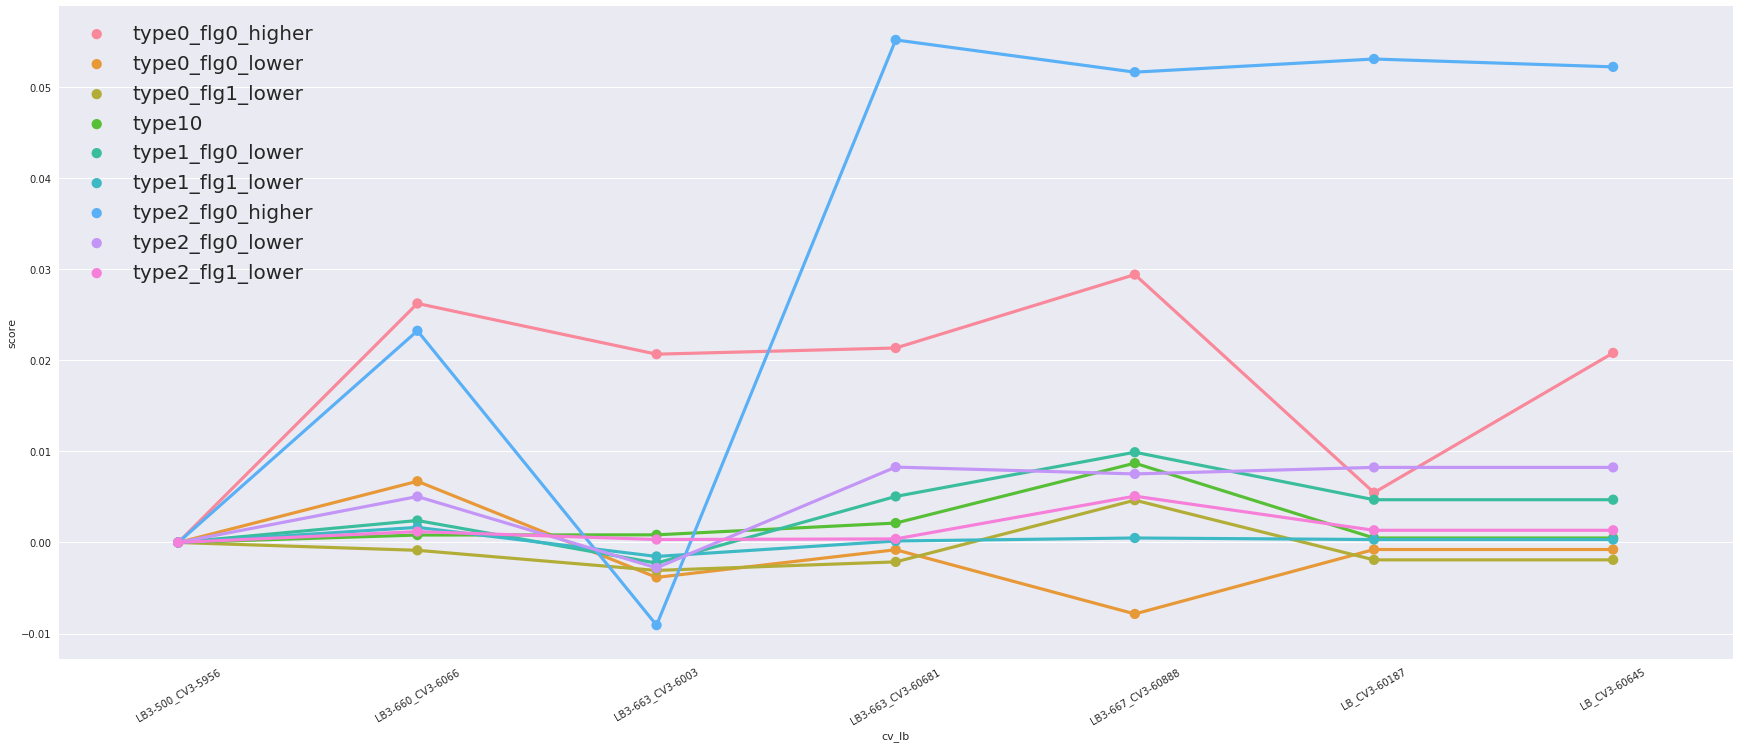

In [46]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def get_new_columns(name,aggs):
#     return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

cv_lb_list = []
score_list = []
fue_list = []
for group in group_list:
    tmp_group = train[train['group']==group]
    cnt_id = np.array(tmp_group.index).shape[0]
    if cnt_id<1000:
        continue
    cnt_out = tmp_group['outlier'].sum()
    print(f"Group: {group} | Count ID: {cnt_id} | Count Outlier: {cnt_out}")
    
    for i, lb in enumerate(lb_list):
        y_train = tmp_group[target].values
        y_pred = tmp_group[lb].values
        score = np.sqrt(mean_squared_error(y_train, y_pred))
        if i==0:
            base_score = score
#             print(f"LB: {lb} | CV: {score}")
        else:
#             print(f"LB: {lb} | CV: {score-base_score}")
            pass
        cv_lb_list.append(lb)
        score_list.append(score-base_score)
        fue_list.append(group)

df_viz = pd.DataFrame([fue_list, cv_lb_list, score_list]).T
df_viz.columns = ['group', 'cv_lb', 'score']

plt.figure(figsize=(30, 12))
sns.pointplot(data=df_viz, x='cv_lb', y='score', hue='group')
# sns.pointplot(data=df_viz[df_viz['group']=='type10'], x='cv_lb', y='score', hue='group')
plt.xticks(rotation='30')
plt.legend(fontsize=20)
plt.show()

In [25]:
# group = 'type0_flg0_higher'
# group = 'type2_flg0_lower'
# group_list = ['type0_flg0_higher']
# lb_list = [col for col in train.columns if col.count('LB')]
# use_cols = [target] + lb_list

# is_clf = 0
# if is_clf:
#     clf_plus = utils.read_pkl_gzip('../stack/0223_153_clf_lgb_out_part-clf_valid-ods_equal_foldseed328_ESET0_row201917_lr0.01_77feats_1seed_70leaves_colsample0.325582_iter710_OUT0_CV0-699598597060546_LB.gz').set_index(key)['prediction']
#     clf_col = 'clf_plus'
#     use_cols.append(clf_col)
#     lb_list += [clf_col]
#     train[clf_col] = clf_plus

# for group in group_list:

#     print(f"Group: {group}")
#     df_gr = train[train['group']==group][use_cols]
    
#     df_gr[target] = df_gr[target].map(lambda x: np.round(x,0))
#     aggs = {}
#     for col in lb_list:
#         aggs[col] = ['mean']
# #     aggs[col] = ['mean', 'size']
#     if is_clf:
#         aggs['clf_plus'] = ['mean']
#     df_gr = df_gr.groupby(target)[lb_list].agg(aggs)
#     df_gr.columns = lb_list
# #     df_gr.columns = lb_list + ['cnt']
# #     display(df_gr['cnt'].to_frame().T)
    
#     if is_clf:
#         lb_list = [clf_col]
    
#     tate_list = []
#     for col in lb_list:
#         tmp = df_gr[col]
#         tmp.name = 'prediction'
#         tmp = tmp.to_frame()
#         tmp['LB'] = col
#         tate_list.append(tmp)
#     df_gr = pd.concat(tate_list, axis=0).reset_index()
    
#     plt.figure(figsize=(24, 4))
#     sns.pointplot(data=df_gr, x='target', y='prediction', hue='LB')
#     plt.xticks(rotation='30')
#     plt.legend(fontsize=20)
#     plt.show()

Group: type0_flg0_higher | Count ID: 28285 | Count Outlier: 1717


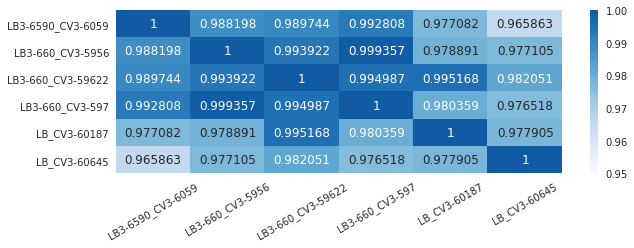

Group: type0_flg0_lower | Count ID: 19040 | Count Outlier: 90


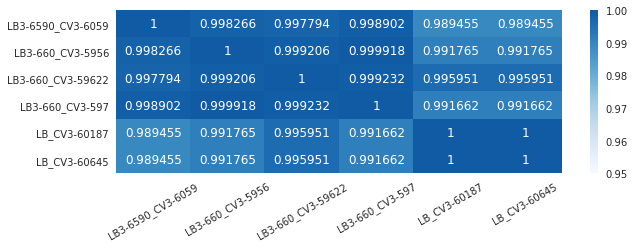

Group: type0_flg1_lower | Count ID: 1546 | Count Outlier: 4


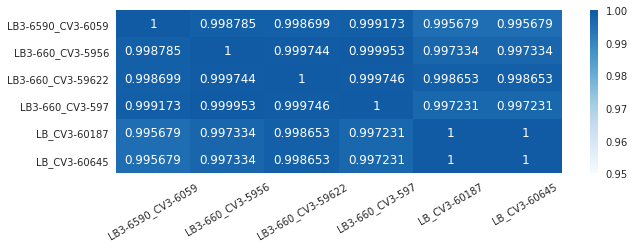

Group: type10 | Count ID: 27766 | Count Outlier: 0


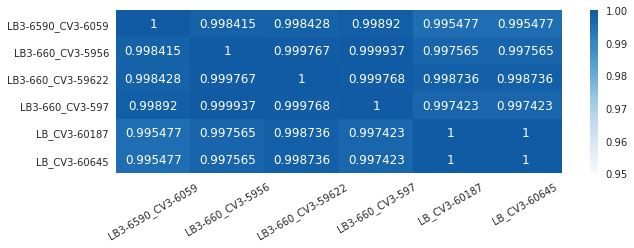

Group: type1_flg0_lower | Count ID: 10161 | Count Outlier: 14


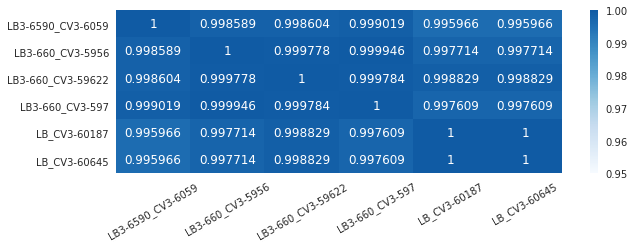

Group: type1_flg1_lower | Count ID: 7430 | Count Outlier: 11


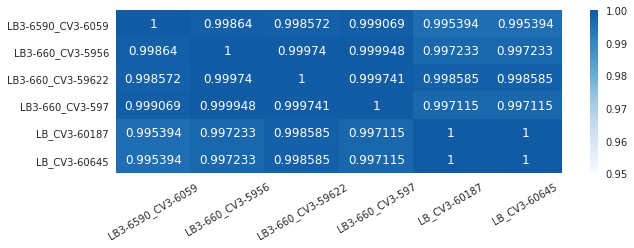

Group: type2_flg0_higher | Count ID: 5540 | Count Outlier: 96


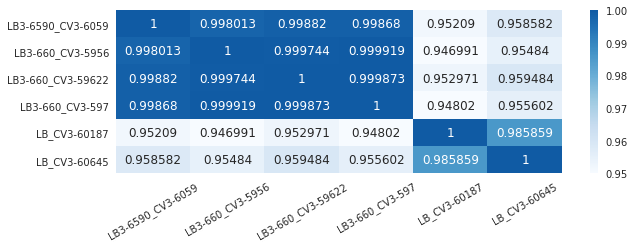

Group: type2_flg0_lower | Count ID: 97628 | Count Outlier: 273


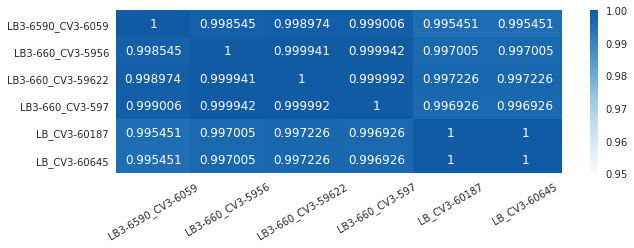

Group: type2_flg1_lower | Count ID: 4431 | Count Outlier: 0


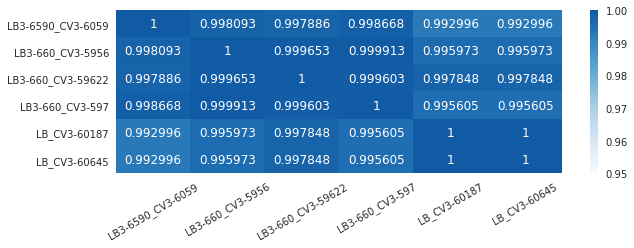

In [26]:
#========================================================================
# Corr Check
train = base[~base[target].isnull()]
train['outlier'] = train[target].map(lambda x: 1 if x<-30 else 0)
for group in group_list:
    tmp_group = train[train['group']==group]
    cnt_id = np.array(tmp_group.index).shape[0]
    if cnt_id<1000:
        continue
    cnt_out = tmp_group['outlier'].sum()
    print(f"Group: {group} | Count ID: {cnt_id} | Count Outlier: {cnt_out}")
    
    lb_list = sorted([col for col in tmp_group.columns if col.count('LB')])
    
    df_corr = tmp_group[lb_list]
    df_corr = df_corr.corr(method='pearson')
    plt.figure(figsize=(10, 3))
    sns.heatmap(df_corr, center = 0.98, vmin=0.95, annot=True, fmt='g', cmap='Blues')
    plt.xticks(rotation='30')
    plt.yticks(rotation='0')
    plt.show()

#========================================================================

In [16]:
#========================================================================
# alijsのOOFを結合して自分仕様にする
#========================================================================
from itertools import combinations
oof_list = glob.glob('../log_submit/alijs_submit/*2325*.csv')
oof_combi = combinations(oof_list, 2)
tmp_list = []
for p1, p2 in oof_combi:
    if p1==p2:continue
    if p1[-8:]!=p2[-8:]:continue
    
    tmp1 = pd.read_csv(p1)
    tmp2 = pd.read_csv(p2)
    if len(tmp1.columns)==3:
        tmp1.drop(target, axis=1, inplace=True)
    if len(tmp2.columns)==3:
        tmp2.drop(target, axis=1, inplace=True)
        
    cv = re.search(r'CV([^/.]*)_LB', p1.replace('.', '-')).group(1)
    lb = re.search(r'LB([^/.]*).csv', p1.replace('.', '-')).group(1)
    pred_col = 'prediction'
        
    tmp1.columns = [key, pred_col]
    tmp2.columns = [key, pred_col]
    df = pd.concat([tmp1, tmp2], axis=0)
    print(p1, p2)
    save_path = f'../ensemble/good_submit_ensemble/0227_alijs_stack_submit_CV{cv}_LB{lb}'
    utils.to_pkl_gzip(obj=df, path=save_path)

../log_submit/alijs_submit/ens_02262325_CV3.5956_LB3.660.csv ../log_submit/alijs_submit/cv_ens_02262325_CV3.5956_LB3.660.csv
../log_submit/alijs_submit/ens_02262325_CV3.5956_LB3.660.csv ../log_submit/alijs_submit/cv_ens_02262325_CV3.5956_LB3.660.csv


In [270]:
#========================================================================
# targetのプラスマイナスの閾値でwith outlierグループを分割できないか考える
#========================================================================
clf_plus = utils.read_pkl_gzip('../stack/0223_153_clf_lgb_out_part-clf_valid-ods_equal_foldseed328_ESET0_row201917_lr0.01_77feats_1seed_70leaves_colsample0.325582_iter710_OUT0_CV0-699598597060546_LB.gz').set_index(key)['prediction']
clf_col = 'clf_minus'
train[clf_col] = clf_plus
train[clf_col] = train[clf_col].map(lambda x: np.round(x,1))

rm_out = utils.read_pkl_gzip('../ensemble/LB3662_stack_set/0220_224_stack_ridge_set-rm_out_valid-term-seed328_lgb5_NN0_ridge0_ext0_rmf0_OUT0_CV1.5459512546222733_LB.gz').set_index(key)['prediction']
rm_col = 'rm_out_pred'
train[rm_col] = rm_out

rm_imp = utils.read_pkl_gzip('../stack/0209_092_stack_lgb_lr0.01_289feats_1seed_70leaves_iter1694_OUT0_CV8-42161536313303_LB.gz').set_index(key)['prediction']
rm_imp_col = 'rm_imp_pred'
train[rm_imp_col] = rm_imp

train['no_out_target'] = train[target].map(lambda x: np.nan if x<-30 else x)
train['outlier'] = train[target].map(lambda x: 1 if x<-30 else 0)
df_gr = train[train['group']=='type0_flg0_higher']

aggs = {}
aggs[target] = ['mean','max', 'min', 'size']
aggs['no_out_target'] = ['mean','max', 'min']
aggs['outlier'] = ['sum']
aggs['LB3-6590_CV3-605'] = ['mean','max', 'min']
aggs[rm_col] = ['mean','max', 'min']
aggs['clf_pred'] = ['mean','max', 'min']


new_cols = [f"{key}_{val}" for key in aggs.keys() for val in aggs[key]]
clf_viz = df_gr.groupby(clf_col)[['outlier', target, 'no_out_target', 'LB3-6590_CV3-605', rm_col, 'clf_pred']].agg(aggs)
clf_viz.columns = new_cols
clf_viz['ratio'] = clf_viz['outlier_sum'] / clf_viz['target_size']
clf_viz

,target_mean,target_max,target_min,target_size,no_out_target_mean,no_out_target_max,no_out_target_min,outlier_sum,LB3-6590_CV3-605_mean,LB3-6590_CV3-605_max,LB3-6590_CV3-605_min,rm_out_pred_mean,rm_out_pred_max,rm_out_pred_min,clf_pred_mean,clf_pred_max,clf_pred_min,ratio
clf_minus,,,,,,,,,,,,,,,,,,
0.1,-2.111199,7.976341,-33.219281,80,0.411078,7.976341,-1.000000,6,-1.005792,0.840276,-4.771482,0.173290,0.350435,-0.043818,0.034296,0.095613,0.010173,0.075000
0.2,0.240576,10.474853,-33.219281,546,1.512814,10.474853,-4.382094,20,0.521398,3.578121,-6.244821,1.457349,3.828848,0.007065,0.026157,0.188222,0.010021,0.036630
0.3,0.053474,15.994455,-33.219281,3933,1.236155,15.994455,-13.872483,135,-0.183854,3.065808,-7.737980,1.220208,3.317567,-0.214698,0.038442,0.299569,0.010003,0.034325
0.4,-1.195793,9.643856,-33.219281,5186,0.556153,9.643856,-8.588461,269,-1.111031,1.506697,-11.146255,0.595785,2.674415,-0.813987,0.046051,0.439387,0.010006,0.051870
0.5,-2.309585,13.350895,-33.219281,4560,0.038910,13.350895,-11.358102,322,-2.139364,0.714107,-17.106536,0.051321,2.435340,-0.928911,0.058102,0.480768,0.010021,0.070614
0.6,-3.184868,7.733897,-33.219281,4898,-0.419158,7.733897,-10.113599,413,-2.967124,0.341984,-21.318788,-0.367093,1.860068,-1.457096,0.068534,0.606286,0.010001,0.084320
0.7,-2.833946,6.425304,-33.219281,4226,-0.825632,6.425304,-15.400146,262,-3.067886,-0.037627,-23.028027,-0.777976,0.850162,-1.974209,0.059215,0.596424,0.010001,0.061997
0.8,-3.107721,4.678328,-33.219281,3419,-1.246789,4.678328,-15.081151,199,-3.214308,-0.099772,-20.230799,-1.224831,-0.396839,-2.497502,0.050097,0.627420,0.010002,0.058204
0.9,-4.017018,2.651656,-33.219281,1437,-2.042720,2.651656,-14.220000,91,-3.817802,-1.025988,-22.478462,-1.961839,-0.786503,-4.133310,0.046362,0.567377,0.010009,0.063326


In [ ]:
# check cv
df = df_gr.copy()
pred_col = 'prediction'
base_pred = 'LB3-6590_CV3-605'

df[pred_col] = df[base_pred]
ratio_max = np.array(list(out_ratio.values())).max()
df['out_ratio'] = df['clf_minus'].map(lambda x: out_ratio[x] / ratio_max )

df.loc[df[rm_col].isnull(), rm_col] = df.loc[df[rm_col].isnull(), rm_imp_col]
# df[pred_col] = (df[base_pred] * df['clf_minus'].map(lambda x: x)) + (df[rm_col] * df['clf_minus'].map(lambda x: (1-x)))
# df[pred_col] = (df[base_pred] * df['out_ratio'].map(lambda x: x)) + (df[rm_col] * df['out_ratio'].map(lambda x: (1-x)))
df.loc[df['clf_minus']==0.2, pred_col] = df.loc[df['clf_minus']==0.2, pred_col]*0.5 + df.loc[df['clf_minus']==0.3, rm_col]*0.5
df.loc[df['clf_minus']==0.3, pred_col] = df.loc[df['clf_minus']==0.3, pred_col]*0.8 + df.loc[df['clf_minus']==0.3, rm_col]*0.2

y_pred = df[pred_col]
y_train = df[target]
score = np.sqrt(mean_squared_error(y_train, y_pred))
score

In [268]:
df_gr.head()

,target,first_active_month,hist_purchase_date_max,hist_purchase_month_max,hist_purchase_date_min,hist_purchase_month_min,new_purchase_date_max,new_purchase_month_max,new_purchase_date_min,new_purchase_month_min,hist_personal_term,new_personal_term,hist_regist_term,new_regist_term,no_out_flg,clf_pred,type,LB3-6590_CV3-605,LB3-658_CV3-603,LB_CV3-617,group,outlier,clf_minus,rm_out_pred,no_out_target,rm_imp_pred
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_0894217f2f,0.871585,2016-09-01,2017-07-29 15:37:18,2017-08-01,2017-01-10 17:14:53,2017-01-01,2017-09-15 21:06:17,2017-10-01,2017-08-15 10:17:55,2017-08-01,7,2.0,11,13.0,0.0,0.043221,0,-1.893529,-1.777819,-1.806451,type0_flg0_higher,0,0.6,-0.648290,0.871585,-0.509479
C_ID_022b48f3ac,1.233601,2016-11-01,2017-12-30 17:00:57,2018-01-01,2017-01-03 16:40:01,2017-01-01,2018-01-12 12:00:08,2018-02-01,2018-01-04 13:25:00,2018-01-01,12,1.0,14,15.0,0.0,0.072283,0,-5.003621,-4.737016,-3.075634,type0_flg0_higher,0,0.7,-0.884405,1.233601,-0.813759
C_ID_0fb5eebcbb,0.605185,2016-08-01,2017-12-30 17:51:05,2018-01-01,2017-01-05 11:18:28,2017-01-01,2018-02-07 07:25:50,2018-03-01,2018-02-07 07:25:50,2018-02-01,12,1.0,17,18.0,0.0,0.029494,0,-1.534179,-1.531221,-0.945454,type0_flg0_higher,0,0.5,0.089860,0.605185,0.019554
C_ID_5967df7a42,-0.469086,2016-04-01,2017-12-19 00:45:01,2018-01-01,2017-01-09 10:10:27,2017-01-01,2018-02-28 10:02:30,2018-03-01,2018-01-17 11:18:33,2018-01-01,12,2.0,21,18.0,0.0,0.030236,0,-1.725847,-2.026241,-2.269656,type0_flg0_higher,0,0.5,0.066439,-0.469086,-0.073424
C_ID_f2e927e5da,3.659081,2017-02-01,2018-01-15 09:10:35,2018-02-01,2017-02-13 19:54:02,2017-02-01,NaT,NaT,NaT,NaT,12,NaN,12,NaN,0.0,0.010352,0,0.390888,0.412742,0.399431,type0_flg0_higher,0,0.4,0.410663,3.659081,0.321198
